In [6]:
%load_ext autoreload
%autoreload 1
%aimport util_csv
%aimport util_image
%aimport runner

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [2]:
from runner import *
from util_image import *
from util_csv import NewFileName
from runner import DataBase as DB
from Timer import Timer 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data_path =  'data/org'

data = Timer.run(lambda :DB.CreateFromFile('data/org'))
data_path = data.params[BaseDir]
data.describe()

---------------------------------------------------------------
elapsed time: 10.931 secs
---------------------------------------------------------------


,steer,gas,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


### Data Input

Count :          Ranges
 4440 : [ -0.00373,  0.00275 ]
  237 : [  0.17112,  0.17759 ]
  179 : [ -0.14619, -0.13971 ]


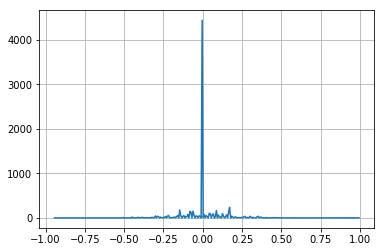

Count :          Ranges
 4440 : [ -0.00373,  0.00275 ]
  237 : [  0.17112,  0.17759 ]
  179 : [ -0.14619, -0.13971 ]


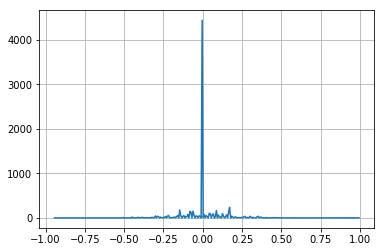

Count :          Ranges
 4440 : [ -0.00373,  0.00275 ]
  237 : [  0.17112,  0.17759 ]
  179 : [ -0.14619, -0.13971 ]


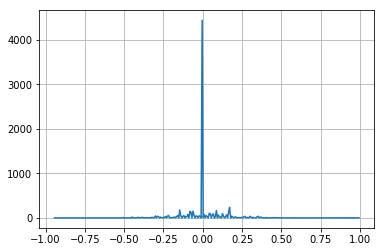

Count :          Ranges
 4440 : [ -0.00373,  0.00275 ]
  237 : [  0.17112,  0.17759 ]
  179 : [ -0.14619, -0.13971 ]


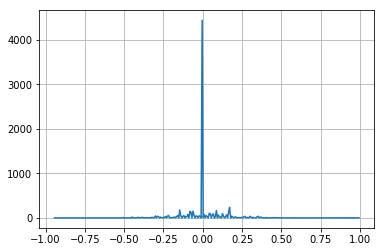

Count :          Ranges
 4440 : [ -0.00373,  0.00275 ]
  237 : [  0.17112,  0.17759 ]
  179 : [ -0.14619, -0.13971 ]


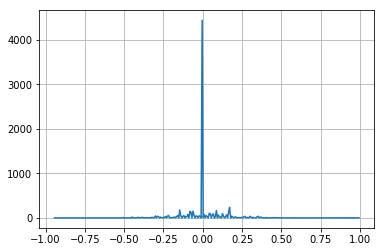

Count :          Ranges
 4440 : [ -0.00373,  0.00275 ]
  237 : [  0.17112,  0.17759 ]
  179 : [ -0.14619, -0.13971 ]


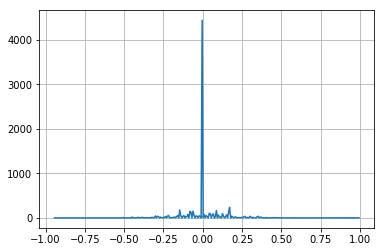

Count :          Ranges
 4440 : [ -0.00373,  0.00275 ]
  237 : [  0.17112,  0.17759 ]
  179 : [ -0.14619, -0.13971 ]


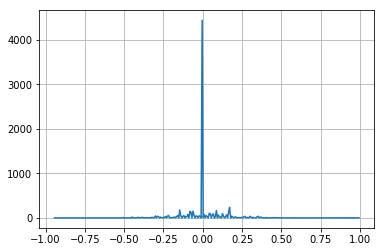

Count :          Ranges
 4440 : [ -0.00373,  0.00275 ]
  237 : [  0.17112,  0.17759 ]
  179 : [ -0.14619, -0.13971 ]


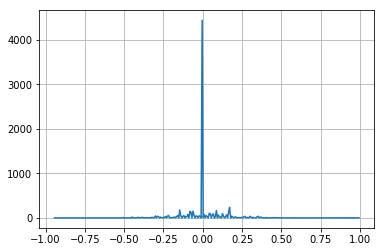

Count :          Ranges
 4440 : [ -0.00373,  0.00275 ]
  237 : [  0.17112,  0.17759 ]
  179 : [ -0.14619, -0.13971 ]


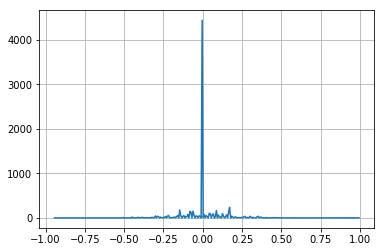

Count :          Ranges
 4440 : [ -0.00373,  0.00275 ]
  237 : [  0.17112,  0.17759 ]
  179 : [ -0.14619, -0.13971 ]


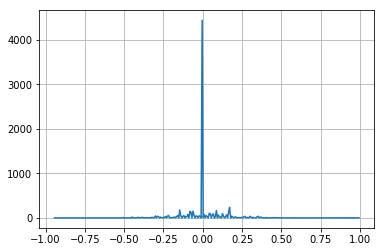

Count :          Ranges
 4440 : [ -0.00373,  0.00275 ]
  237 : [  0.17112,  0.17759 ]
  179 : [ -0.14619, -0.13971 ]


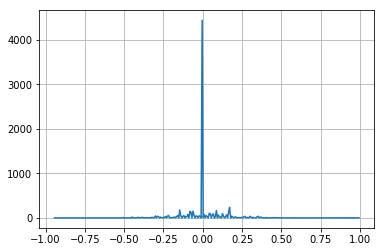

,steer,gas,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


In [102]:

def show_data_distribution(datas, bins=300, scan=0):
    dhist, dbins = np.histogram(datas, bins=bins)
    sortInd = dhist.argsort()

    print("{:5s} :          Ranges".format("Count"))
    ranges = []
    for i in range(3): 
        ind = sortInd[-(i+1)]
        cnt = dhist[ind]
        print("{:5d} : [ {: 5.5f}, {: 5.5f} ]".format(cnt, dbins[ind], dbins[ind+1]))
        ranges.append([cnt, dbins[ind], dbins[ind+1]])
    ax = plt.plot(dbins[:-1],dhist)
    plt.grid('on')
#     plt.xlim(np.array([ 0, -0.03])-scan)
    plt.show()
    return ranges

for i in range(10): show_data_distribution(data.steer, scan=i*0.002)

data.params['top3'] = show_data_distribution(data.steer)
data.describe()


## Pre-Process

Take 5% of the most occuring data

len BA = 4440, n = 4218, maxInds = 8035
Count :          Ranges
  237 : [  0.17112,  0.17759 ]
  222 : [ -0.00373,  0.00275 ]
  179 : [ -0.14619, -0.13971 ]


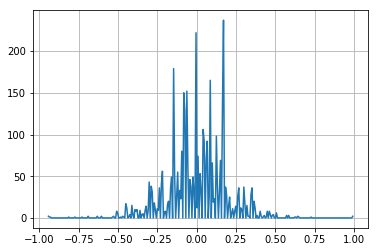

[[237, 0.17111662933333338, 0.17759228066666666],
 [222, -0.003725956666666641, 0.0027496946666666355],
 [179, -0.14619028600000006, -0.13971463466666667]]

In [106]:
from random import sample

rngs = data.params['top3'][0]

inds_within_range = (data.steer >= rngs[1]) & (data.steer <= rngs[2]) 
dataSmall = data.grab(inds_within_range,pcent=0.05)
show_data_distribution(dataSmall.steer, bins=300)

## Add Flipped Images

In [108]:
flipped = AddFlippedImages(dataSmall, skip_range=(-0.1, 0.1))

Count :          Ranges
  439 : [ -0.00373,  0.00275 ]
  245 : [ -0.09439, -0.08791 ]
  245 : [  0.08693,  0.09341 ]


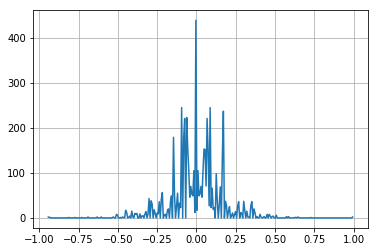

[[439, -0.003725956666666641, 0.0027496946666666355],
 [245, -0.09438507533333329, -0.087909424000000014],
 [245, 0.086933161999999897, 0.093408813333333396]]

In [111]:
show_data_distribution(flipped.steer, bins=300)

Count :          Ranges
  237 : [  0.17112,  0.17759 ]
  222 : [ -0.00373,  0.00275 ]
  179 : [ -0.14619, -0.13971 ]


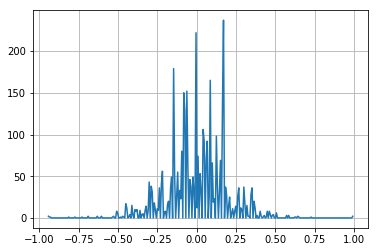

[[237, 0.17111662933333338, 0.17759228066666666],
 [222, -0.003725956666666641, 0.0027496946666666355],
 [179, -0.14619028600000006, -0.13971463466666667]]

## Train

In [113]:
path=NewFileName('models/model_f.h5')
tr = Timer.run(lambda:NVidia(flipped))
res = Timer.run(lambda: tr.train(epoch=30, verbose=1, path=path))

print("Model Saved At: " + path)
# res = tr.train(epoch=20, verbose=1, path=NewFileName('models/model.h5'))



# path=NewFileName('models/model_nf.h5')
# tr = Timer.run(lambda:NVidia(dataSmall))
# res = Timer.run(lambda: tr.train(epoch=15, verbose=1, path=path))

# print("Model Saved At: " + path)



/home/carnd/p3/runner.py:240: UserWarning: Update your `Cropping2D` call to the Keras 2 API: `Cropping2D(input_shape=(160, 320,..., data_format="channels_last", cropping=((70, 25),...)`
  input_shape=(160, 320, 3)))
/home/carnd/p3/runner.py:249: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), strides=(4, 4), padding="same")`
  model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
/home/carnd/p3/runner.py:253: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), strides=(2, 2), padding="same")`
  model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
/home/carnd/p3/runner.py:257: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), strides=(2, 2), padding="same")`
  model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))


---------------------------------------------------------------
elapsed time: 1.896 secs
---------------------------------------------------------------


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 4418 samples, validate on 1105 samples
Epoch 1/30
4418/4418 [==============================] - 6s - loss: 0.0296 - acc: 0.0672 - val_loss: 0.0090 - val_acc: 0.1231

In [117]:
tr.model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])
tr.model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_2 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 17, 80, 16)        3088      
_________________________________________________________________
elu_6 (ELU)                  (None, 17, 80, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 40, 32)         12832     
_________________________________________________________________
elu_7 (ELU)                  (None, 9, 40, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 20, 64)         51264     
__________